## Train and evaluate models using RGB input

In [ ]:
import sys
sys.path.append('../')

from anomalib.metrics import AUROC, AUPRO
from src.experiments.eval import EvalExperiment

# constants for all experiments
image_size = (256, 256)
models = ["Patchcore", "ReverseDistillation", "Fastflow"]
datasets = ["Visa"]

# metrics, image-level AUROC and pixel-level AUPRO
metrics = [
        AUROC(fields=["pred_score", "gt_label"], prefix="image_"),
        AUPRO(fields=["anomaly_map", "gt_mask"], prefix="pixel_"),
]

# create an experiment
experiment = EvalExperiment(root="../")
experiment_name = "eval_rgb"

# setup experiment with selected models and datasets, pass metrics
experiment.setup(
    models=models, 
    datasets=datasets,
    experiment_name=experiment_name,
    metrics=metrics,
    image_size=image_size
)

# run training and evaluation
experiment.run()

In [21]:
from src.utils.metrics_reader import MetricsReader

# read results
mlruns_path = "../mlruns"
mr = MetricsReader(mlruns_path=mlruns_path)
mr.print_metrics(experiment_names=[experiment_name])

Processing experiment: eval_rgb
|    | model               | dataset   |   image_AUROC |   pixel_AUPRO |
|---:|:--------------------|:----------|--------------:|--------------:|
|  0 | Fastflow            | Visa      |       83.4801 |       71.0607 |
|  1 | Patchcore           | Visa      |       90.467  |       86.2186 |
|  2 | ReverseDistillation | Visa      |       95.0785 |       90.6657 |
|  3 | glass               | Visa      |       94.1254 |       85.5693 |


## Train and evaluate models using grayscale input with 3 channels

In [22]:
from torchvision.transforms.v2 import Compose, Normalize, Resize, Grayscale
import torch

# normalisation - use mean of Imagenet values
gs_mean = torch.mean(torch.tensor([0.485, 0.456, 0.406]))
gs_std = torch.mean(torch.tensor([0.229, 0.224, 0.225]))

# grayscale transform
num_output_channels = 3
gs_transform = Compose([
    Resize(image_size, antialias=True),
    Grayscale(num_output_channels=num_output_channels),
    Normalize(mean=[gs_mean]*num_output_channels, std=[gs_std]*num_output_channels),
])
gs_transform

Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      Grayscale(num_output_channels=3)
      Normalize(mean=[tensor(0.4490), tensor(0.4490), tensor(0.4490)], std=[tensor(0.2260), tensor(0.2260), tensor(0.2260)], inplace=False)
)

In [23]:
# create an experiment
experiment = EvalExperiment(root="../")

experiment_name = "eval_grayscale_3ch"

# setup experiment with selected models and datasets, pass metrics
experiment.setup(
    models=models, 
    datasets=datasets,
    experiment_name=experiment_name,
    metrics=metrics,
    transform=gs_transform,
)

# run training and evaluation
experiment.run()

In [24]:
# read results
mr = MetricsReader(mlruns_path=mlruns_path)
mr.print_metrics(experiment_names=[experiment_name])

Processing experiment: eval_grayscale_3ch
|    | model               | dataset   |   image_AUROC |   pixel_AUPRO |
|---:|:--------------------|:----------|--------------:|--------------:|
|  0 | Fastflow            | Visa      |       82.3806 |       67.416  |
|  1 | Patchcore           | Visa      |       90.0408 |       85.7267 |
|  2 | ReverseDistillation | Visa      |       94.9767 |       90.9446 |
|  3 | glass               | Visa      |       92.6853 |       80.2351 |


## Train and evaluate models using grayscale input with 1 channel

### Make these changes in Anomalib to be able to use one channel images.

1. For Patchcore and ReverseDistillation add `in_chans=1` to `timm.create_model()` in `anomalib\src\anomalib\models\components\feature_extractors\timm.py`:
```python
self.feature_extractor = timm.create_model(
    backbone,
    pretrained=pre_trained,
    pretrained_cfg=None,
    features_only=True,
    exportable=True,
    out_indices=self.idx,
    in_chans=1,
)
```

2. For Fastflow add the same in `anomalib\src\anomalib\models\image\fastflow\torch_model.py`:
```python
self.feature_extractor = timm.create_model(
    backbone,
    pretrained=pre_trained,
    features_only=True,
    out_indices=[1, 2, 3],
    in_chans=1,
)
```

3. Update `validate_image()` in `anomalib\src\anomalib\data\validators\torch\image.py` to validate both three and one channels:
```python
if image.shape[1] != 3 and image.shape[1] != 1:
    msg = f"Image must have 1 or 3 channels, got {image.shape[1]}."
    raise ValueError(msg)
```

4. Restart kernel

In [ ]:
import sys
sys.path.append('../')

import torch

from anomalib.metrics import AUROC, AUPRO
from src.experiments.eval import EvalExperiment
from src.utils.metrics_reader import MetricsReader
from torchvision.transforms.v2 import Compose, Normalize, Resize, Grayscale


# constants for all experiments
image_size = (256, 256)
models = ["Patchcore", "ReverseDistillation", "Fastflow"]
datasets = ["Visa"]

# metrics, image-level AUROC and pixel-level AUPRO
metrics = [
        AUROC(fields=["pred_score", "gt_label"], prefix="image_"),
        AUPRO(fields=["anomaly_map", "gt_mask"], prefix="pixel_"),
]

gs_mean = torch.mean(torch.tensor([0.485, 0.456, 0.406]))
gs_std = torch.mean(torch.tensor([0.229, 0.224, 0.225]))

# grayscale transform
num_output_channels = 1
gs_transform = Compose([
    Resize(image_size, antialias=True),
    Grayscale(num_output_channels=num_output_channels),
    Normalize(mean=[gs_mean]*num_output_channels, std=[gs_std]*num_output_channels),
])
gs_transform

Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      Grayscale(num_output_channels=1)
      Normalize(mean=[tensor(0.4490)], std=[tensor(0.2260)], inplace=False)
)

In [26]:
# create an experiment
experiment = EvalExperiment(root="../")

experiment_name = "eval_grayscale_1ch"

# setup experiment with selected models and datasets, pass metrics
experiment.setup(
    models=models, 
    datasets=datasets,
    experiment_name=experiment_name,
    metrics=metrics,
    transform=gs_transform,
)

# run training and evaluation
experiment.run()

In [27]:
mr = MetricsReader(mlruns_path=mlruns_path, experiment_name=experiment_name)
mr.print_metrics()

Processing experiment: eval_grayscale_1ch
|    | model               | dataset   |   image_AUROC |   pixel_AUPRO |
|---:|:--------------------|:----------|--------------:|--------------:|
|  0 | Fastflow            | Visa      |       81.6545 |       65.7176 |
|  1 | Patchcore           | Visa      |       90.7428 |       86.147  |
|  2 | ReverseDistillation | Visa      |       95.0961 |       90.5179 |
|  3 | glass               | Visa      |       89.1061 |       82.289  |


## Compare results

In [29]:
mr.print_metrics()

Processing experiment: eval_rgb
|    | model               | dataset   |   image_AUROC |   pixel_AUPRO |
|---:|:--------------------|:----------|--------------:|--------------:|
|  0 | Fastflow            | Visa      |       83.4801 |       71.0607 |
|  1 | Patchcore           | Visa      |       90.467  |       86.2186 |
|  2 | ReverseDistillation | Visa      |       95.0785 |       90.6657 |
|  3 | glass               | Visa      |       94.1254 |       85.5693 |
Processing experiment: eval_grayscale_3ch
|    | model               | dataset   |   image_AUROC |   pixel_AUPRO |
|---:|:--------------------|:----------|--------------:|--------------:|
|  0 | Fastflow            | Visa      |       82.3806 |       67.416  |
|  1 | Patchcore           | Visa      |       90.0408 |       85.7267 |
|  2 | ReverseDistillation | Visa      |       94.9767 |       90.9446 |
|  3 | glass               | Visa      |       92.6853 |       80.2351 |
Processing experiment: eval_grayscale_1ch
|    | m

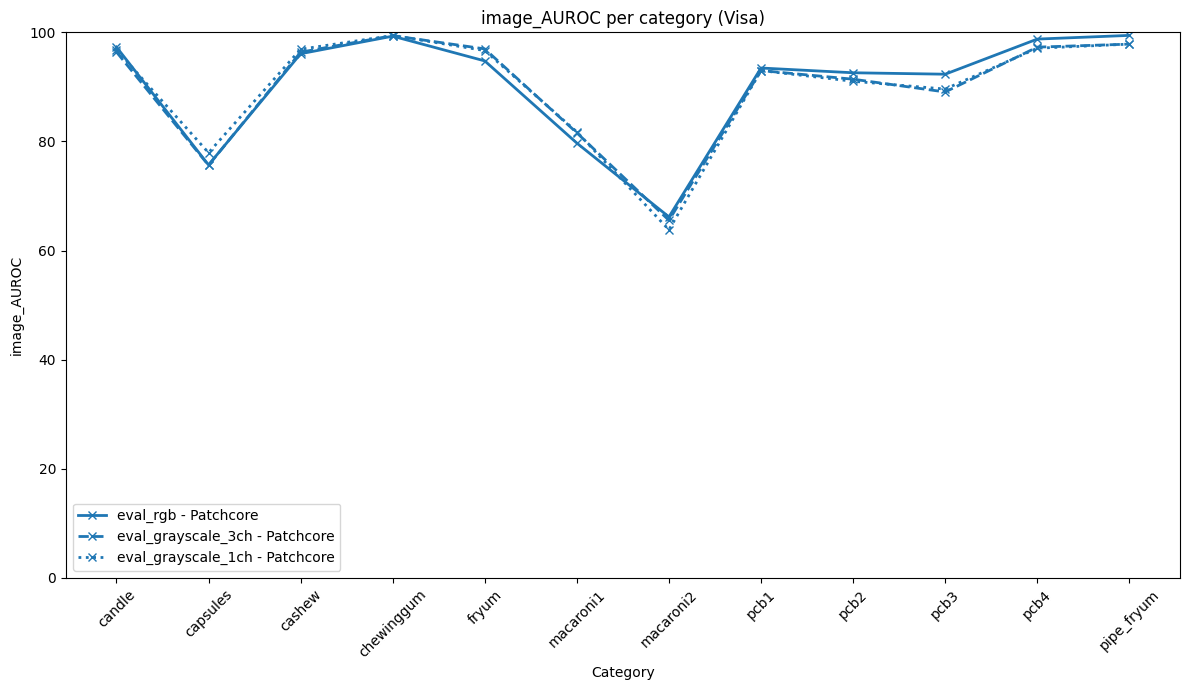

In [5]:
models = ["Patchcore"]
mr.plot_results_per_category(model_names=models, experiment_names=["eval_rgb", "eval_grayscale_3ch", "eval_grayscale_1ch"])

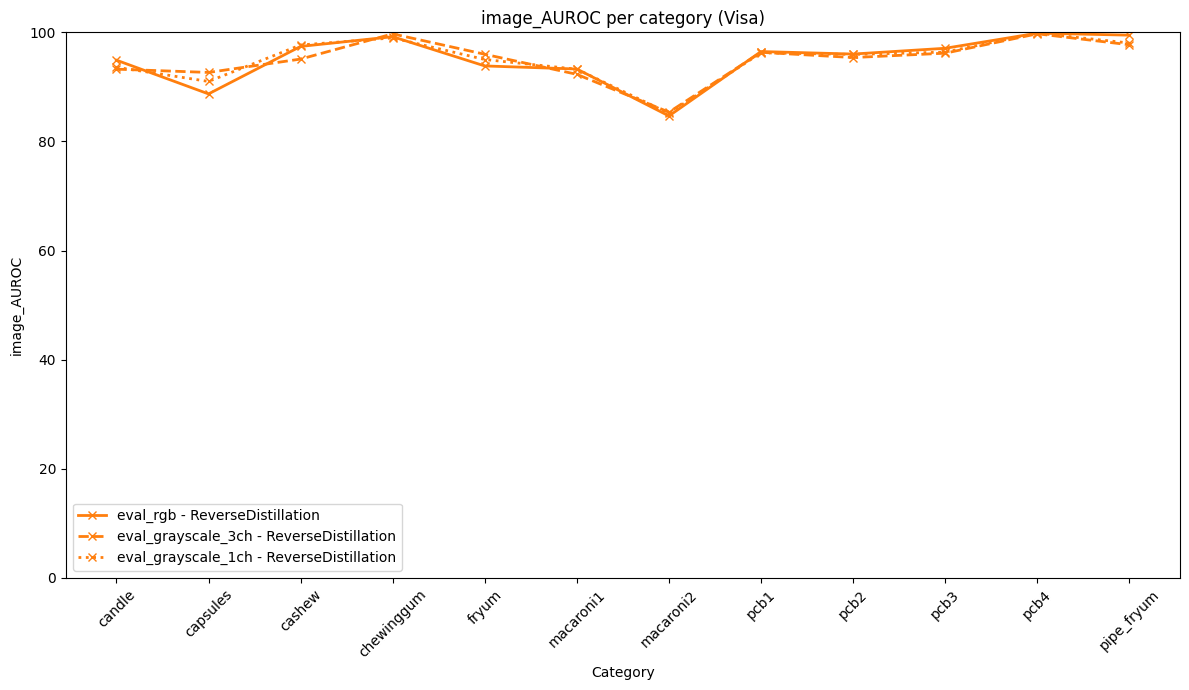

In [7]:
models = ["ReverseDistillation"]
mr.plot_results_per_category(model_names=models, experiment_names=["eval_rgb", "eval_grayscale_3ch", "eval_grayscale_1ch"])

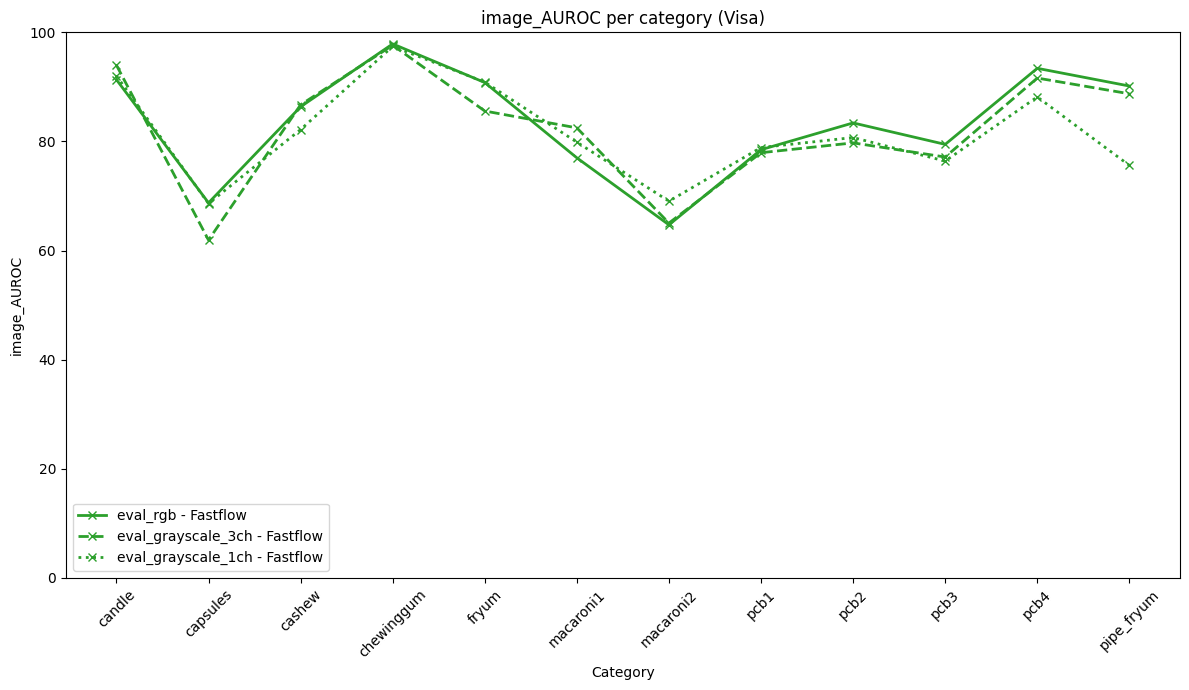

In [8]:
models = ["Fastflow"]
mr.plot_results_per_category(model_names=models, experiment_names=["eval_rgb", "eval_grayscale_3ch", "eval_grayscale_1ch"])

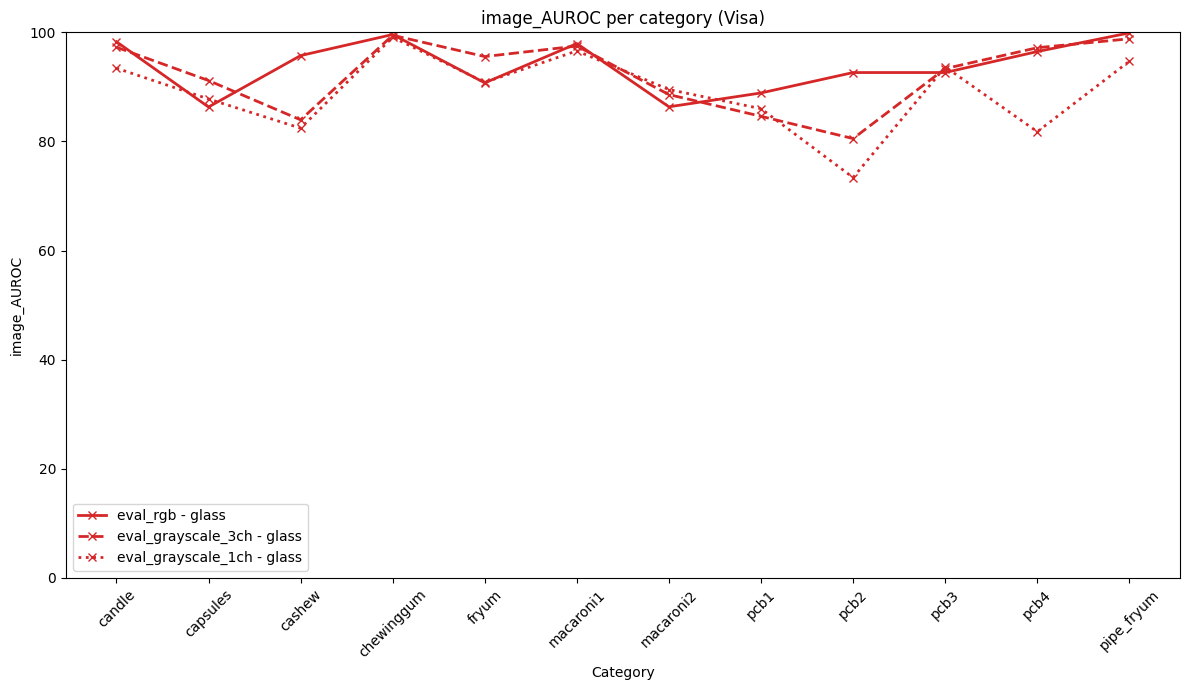

In [6]:
models = ["glass"]
mr.plot_results_per_category(model_names=models, experiment_names=["eval_rgb", "eval_grayscale_3ch", "eval_grayscale_1ch"])

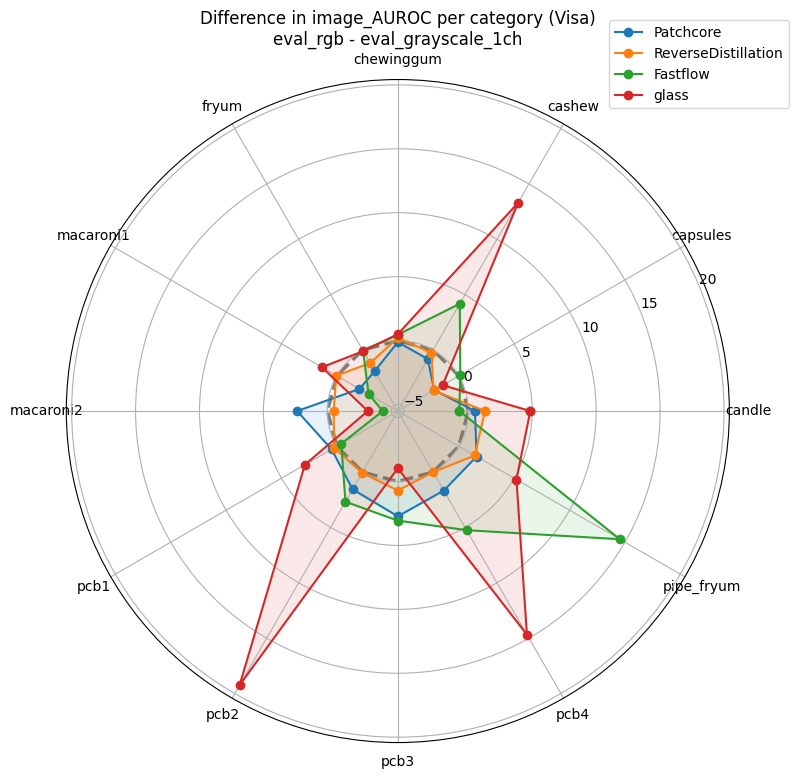

In [3]:
mr.plot_star_chart_difference()

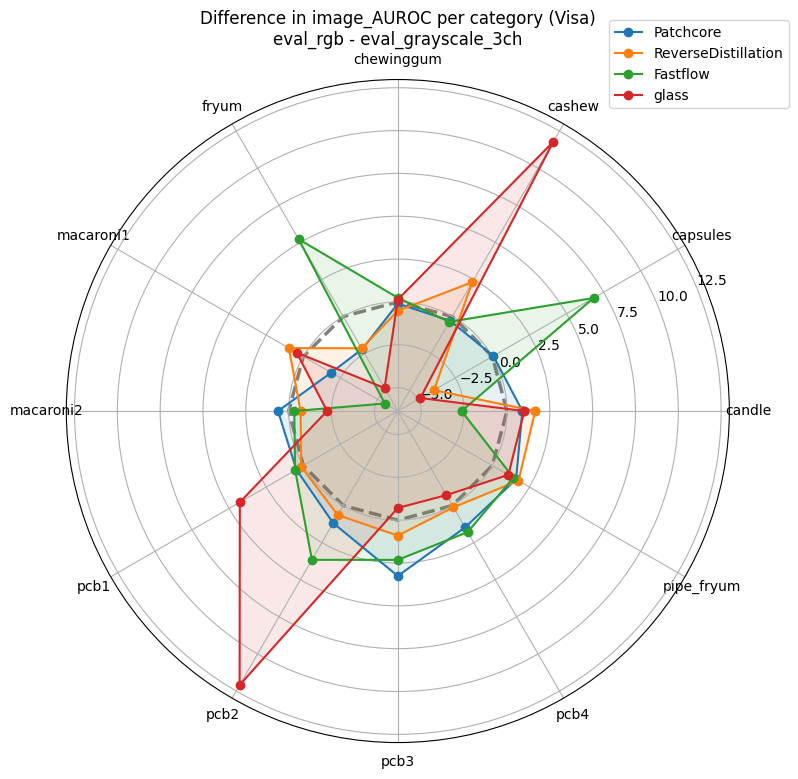

In [9]:
mr.plot_star_chart_difference(experiment2="eval_grayscale_3ch")

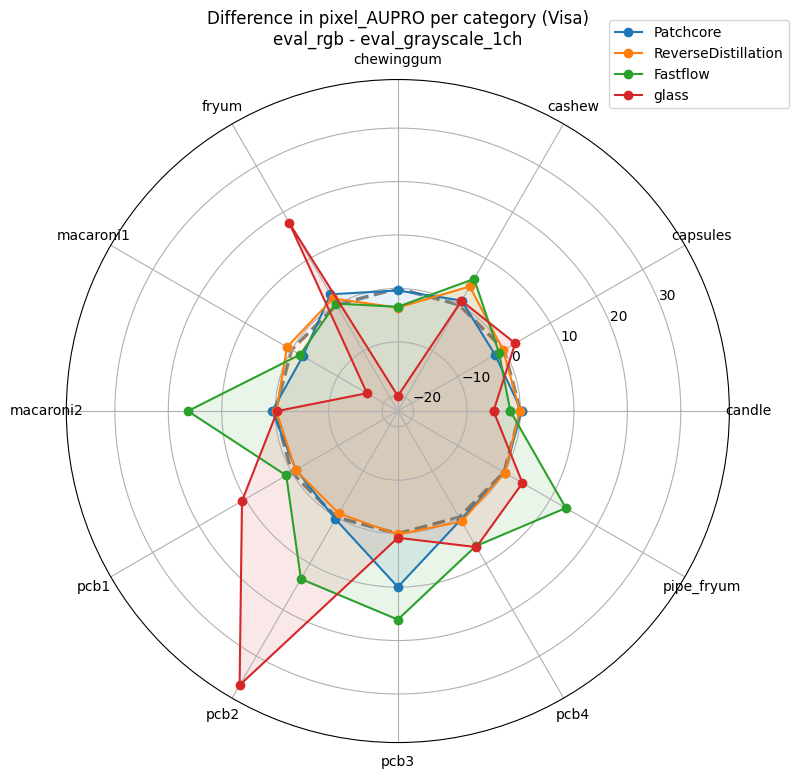

In [10]:
mr.plot_star_chart_difference(metric="pixel_AUPRO")

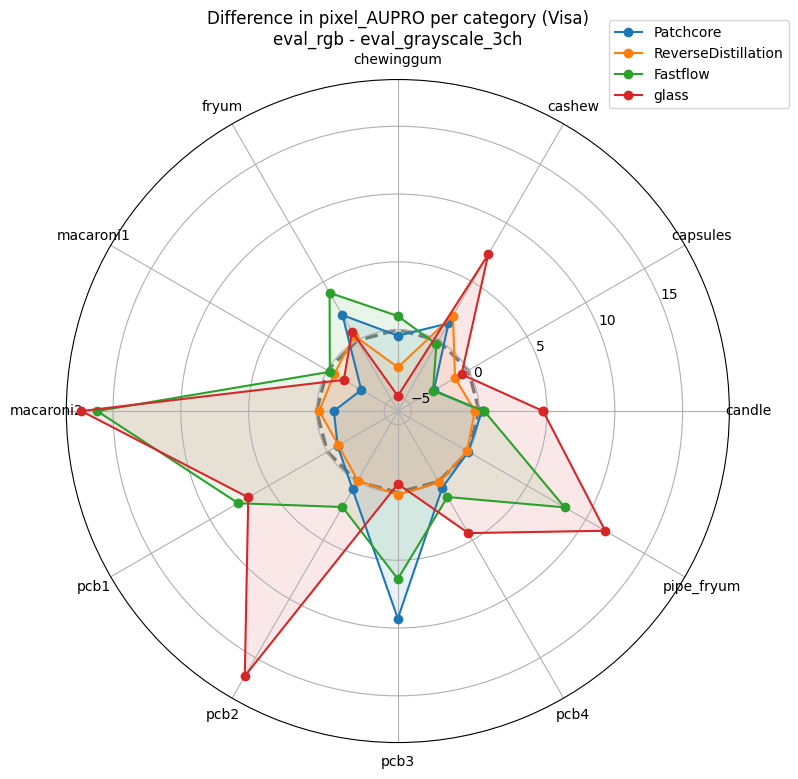

In [11]:
mr.plot_star_chart_difference(metric="pixel_AUPRO", experiment2="eval_grayscale_3ch")